In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
from utils.mdp_description import MDPDescription
from utils.new_mdp_description import NewMDPDescription
from utils.simplified_new_mdp_description import SimplifiedNewMDPDescription
from envs.forked_riverswim import ForkedRiverSwim
from envs.random_mdp import RandomMDP
from scipy.special import rel_entr
from utils.utils import project_omega,compute_stationary_distribution, unit_vector, angle_between, gram_schmidt
import matplotlib.ticker as mticker
from envs.riverswim import RiverSwim
from scipy.stats import bootstrap
from scipy.stats import t

def TV(p,q):
    return np.sum(np.abs(p-q)) * 0.5

def CE(x, c=0.95):
    N = x.shape[0]
    alpha = c + (1-c)/2
    c = t.ppf(alpha, N)
    s = np.std(x, axis=0, ddof=1)
    return x.mean(0), c * s/ np.sqrt(N)

def compute_ce_median(values, c=0.95):
    ce = list(map(lambda k: bootstrap((values[:,k],), np.median, confidence_level=c).confidence_interval, range(values.shape[1])))
    res = np.array([(x.low, x.high) for x in ce])
    return res[:, 0], res[:, 1]


import matplotlib as mpl
TITLE_SIZE = 24
LEGEND_SIZE = 15
TICK_SIZE = 15
AXIS_TITLE = TITLE_SIZE-4
AXIS_LABEL = 18
FONT_SIZE = TITLE_SIZE-4


plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=AXIS_TITLE)     # fontsize of the axes title
plt.rc('axes', labelsize=AXIS_LABEL)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND_SIZE)    # legend fontsize
plt.rc('figure', titlesize=TITLE_SIZE)  # fontsize of the figure title

plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,  # use inline math for ticks
    "pgf.rcfonts": False,  # don't setup fonts from rc parameters
    "pgf.preamble": [
        "\\usepackage{units}",  # load additional packages
        "\\usepackage{metalogo}",
        "\\usepackage{unicode-math}",  # unicode math setup
        r"\setmathfont{xits-math.otf}",
        r'\usepackage{amsmath}',
        r"\setmainfont{DejaVu Serif}",  # serif font via preamble
        r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
        r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
        r'\usepackage{helvet}',    # set the normal font here
        r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
        r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
    ]
})


In [2]:
NS = np.arange(4, 31)
NN = np.arange(3, 31)
NEPS = 10**np.geomspace(-2, np.log10(0.99), 50)
discount_factor = 0.99
np.random.seed(2)

In [4]:
riverswim_res_U_gen_stationary = np.zeros((len(NS), len(NEPS)))
riverswim_res_U_gen_proj = np.zeros((len(NS),len(NEPS)))
riverswim_res_U_nc = np.zeros(len(NS))
riverswim_res_TV_gen_stationary = np.zeros((len(NS),len(NEPS)))
riverswim_res_TV_gen_proj = np.zeros((len(NS),len(NEPS)))
riverswim_res_TV_nc = np.zeros(len(NS))
riverswim_res_U_C = np.zeros(len(NS))

for id_s, NS_RIVER in enumerate(NS):
    env = RiverSwim(num_states=NS_RIVER)

    while True:
        try:
            P0 = np.ones((NS_RIVER, 2, NS_RIVER)) / NS_RIVER
            P = env.transitions
            R = env.rewards
            mdp = NewMDPDescription(P, R, discount_factor)
            omega_nav_constr, _ = mdp.compute_allocation(navigation_constraints=True)
            riverswim_res_U_C[id_s] = mdp.evaluate_allocation(omega_nav_constr)      
            
            mdp_theta = SimplifiedNewMDPDescription(P, R, discount_factor, 1)
            
            omega_gen_theta = mdp_theta.compute_allocation()[0]
            omega_nav_constr_theta, _ = mdp_theta.compute_allocation(navigation_constraints=True)
            riverswim_res_U_nc[id_s] = mdp.evaluate_allocation(omega_nav_constr_theta)
            riverswim_res_TV_nc[id_s] = TV(omega_nav_constr_theta, omega_nav_constr)
            
            # Forced projected generative
            for id_eps, eps in enumerate(NEPS):
                omega_gen_theta_eps = (1-eps)*omega_gen_theta + eps * np.ones((NS_RIVER, 2)) / (NS_RIVER * 2)
                omega_gen_stationary = compute_stationary_distribution(omega_gen_theta_eps, P)
                riverswim_res_TV_gen_stationary[id_s,id_eps] = TV(omega_gen_stationary, omega_nav_constr)
                riverswim_res_U_gen_stationary[id_s,id_eps] = mdp.evaluate_allocation(omega_gen_stationary, navigation_constraints=False)

                # Unforced projected generative
                omega_gen_theta_eps = (1-eps)*omega_gen_theta + eps * np.ones((NS_RIVER, 2)) / (NS_RIVER * 2)
                omega_gen_proj_eps = project_omega(omega_gen_theta_eps, P, force_policy=False)
                riverswim_res_TV_gen_proj[id_s,id_eps] = TV(omega_gen_proj_eps, omega_nav_constr)
                riverswim_res_U_gen_proj[id_s, id_eps] = mdp.evaluate_allocation(omega_gen_proj_eps, navigation_constraints=False)
            break
        except Exception as e:
            print(e)
            continue


with open('./data/data_comparison_proj_3d_riverswim.pkl', 'wb') as f:
    pickle.dump({'riverswim_res_U_gen_stationary': riverswim_res_U_gen_stationary, 'riverswim_res_TV_gen_stationary': riverswim_res_TV_gen_stationary,
                 'riverswim_res_U_gen_proj': riverswim_res_U_gen_proj, 'riverswim_res_TV_gen_proj': riverswim_res_TV_gen_proj,
                 'riverswim_res_U_nc': riverswim_res_U_nc, 'riverswim_res_TV_nc': riverswim_res_TV_nc,
                 'riverswim_res_U_C': riverswim_res_U_C,
                 }, f,  protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
forked_riverswim_res_U_gen_stationary = np.zeros((len(NN), len(NEPS)))
forked_riverswim_res_U_gen_proj = np.zeros((len(NN), len(NEPS)))
forked_riverswim_res_U_nc = np.zeros((len(NN)))
forked_riverswim_res_TV_gen_stationary = np.zeros((len(NN), len(NEPS)))
forked_riverswim_res_TV_gen_proj = np.zeros((len(NN), len(NEPS)))
forked_riverswim_res_TV_nc = np.zeros(len(NN))
forked_riverswim_res_U_C = np.zeros(len(NN))

for id_n, NN_RIVER in enumerate(NN):
    env = ForkedRiverSwim(NN_RIVER)

    ns, na = env.transitions.shape[0], env.transitions.shape[1]

    while True:
        try:
            P0 = np.ones((ns, na, ns)) / ns
            P = env.transitions
            R = env.rewards
            mdp = NewMDPDescription(P, R, discount_factor)
            omega_nav_constr, _ = mdp.compute_allocation(navigation_constraints=True)
            forked_riverswim_res_U_C[id_n] = mdp.evaluate_allocation(omega_nav_constr)      
            
            mdp_theta = SimplifiedNewMDPDescription(P, R, discount_factor, 1)
            
            omega_gen_theta = mdp_theta.compute_allocation()[0]
            omega_nav_constr_theta, _ = mdp_theta.compute_allocation(navigation_constraints=True)
            forked_riverswim_res_U_nc[id_n] = mdp.evaluate_allocation(omega_nav_constr_theta)
            forked_riverswim_res_TV_nc[id_n] = TV(omega_nav_constr_theta, omega_nav_constr)
            
            # Forced projected generative
            for id_eps, eps in enumerate(NEPS):
                omega_gen_theta_eps = (1-eps)*omega_gen_theta + eps * np.ones((ns, na)) / (ns * na)
                omega_gen_stationary = compute_stationary_distribution(omega_gen_theta_eps, P)
                forked_riverswim_res_TV_gen_stationary[id_n, id_eps] = TV(omega_gen_stationary, omega_nav_constr)
                forked_riverswim_res_U_gen_stationary[id_n, id_eps] = mdp.evaluate_allocation(omega_gen_stationary, navigation_constraints=False)

                # Unforced projected generative
                omega_gen_theta_eps = (1-eps)*omega_gen_theta + eps * np.ones((ns, na)) / (ns * na)
                omega_gen_proj_eps = project_omega(omega_gen_theta_eps, P, force_policy=False)
                forked_riverswim_res_TV_gen_proj[id_n, id_eps] = TV(omega_gen_proj_eps, omega_nav_constr)
                forked_riverswim_res_U_gen_proj[id_n, id_eps] = mdp.evaluate_allocation(omega_gen_proj_eps, navigation_constraints=False)
            break
        except Exception as e:
            print(e)
            continue


with open('./data/data_comparison_proj_3d_forked_riverswim.pkl', 'wb') as f:
    pickle.dump({'forked_riverswim_res_U_gen_stationary': forked_riverswim_res_U_gen_stationary, 'forked_riverswim_res_TV_gen_stationary': forked_riverswim_res_TV_gen_stationary,
                 'forked_riverswim_res_U_gen_proj': forked_riverswim_res_U_gen_proj, 'forked_riverswim_res_TV_gen_proj': forked_riverswim_res_TV_gen_proj,
                 'forked_riverswim_res_U_nc': forked_riverswim_res_U_nc, 'forked_riverswim_res_TV_nc': forked_riverswim_res_TV_nc,
                 'forked_riverswim_res_U_C': forked_riverswim_res_U_C,
                 }, f,  protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('./data/data_comparison_proj_3d_riverswim.pkl', 'rb') as f:
    data = pickle.load(f)
    

riverswim_res_U_gen_stationary = data['riverswim_res_U_gen_stationary']
riverswim_res_U_gen_proj = data['riverswim_res_U_gen_proj']
riverswim_res_U_nc = data['riverswim_res_U_nc']
riverswim_res_TV_gen_stationary = data['riverswim_res_TV_gen_stationary']
riverswim_res_TV_gen_proj = data['riverswim_res_TV_gen_proj']
riverswim_res_TV_nc = data['riverswim_res_TV_nc']
riverswim_res_U_C = data['riverswim_res_U_C']


with open('./data/data_comparison_proj_3d_forked_riverswim.pkl', 'rb') as f:
    data = pickle.load(f)
    

forked_riverswim_res_U_gen_stationary = data['forked_riverswim_res_U_gen_stationary']
forked_riverswim_res_U_gen_proj = data['forked_riverswim_res_U_gen_proj']
forked_riverswim_res_U_nc = data['forked_riverswim_res_U_nc']
forked_riverswim_res_TV_gen_stationary = data['forked_riverswim_res_TV_gen_stationary']
forked_riverswim_res_TV_gen_proj = data['forked_riverswim_res_TV_gen_proj']
forked_riverswim_res_TV_nc = data['forked_riverswim_res_TV_nc']
forked_riverswim_res_U_C = data['forked_riverswim_res_U_C']

[]

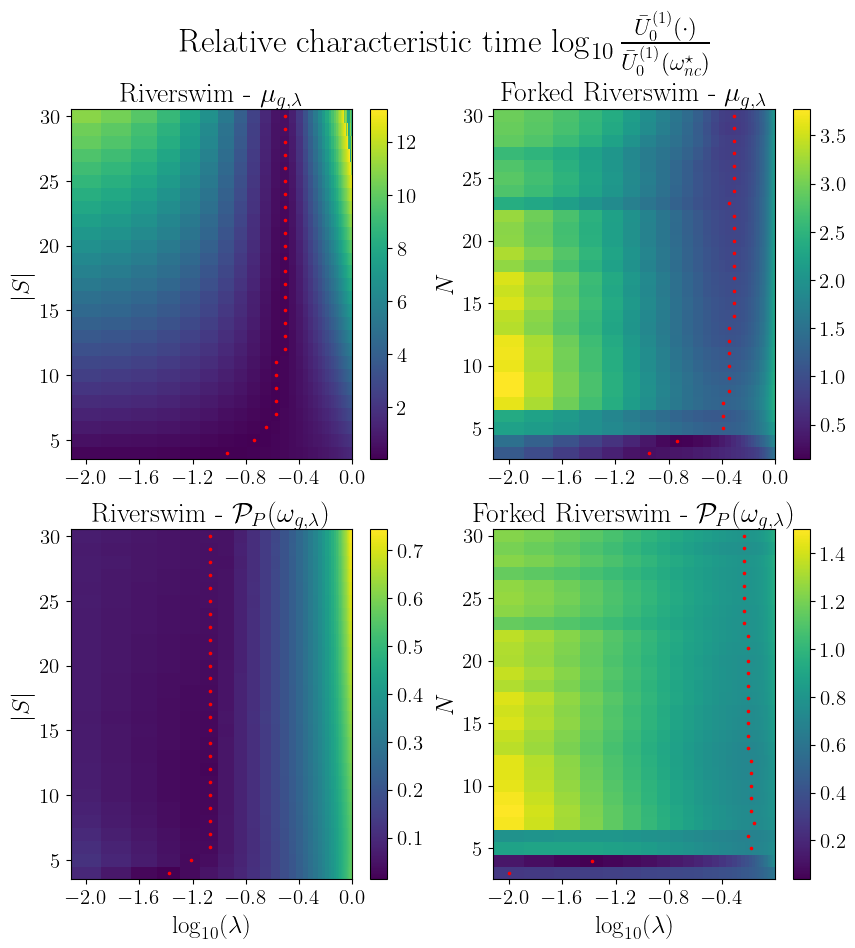

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(10,10))

Z_rv =(riverswim_res_U_gen_stationary / riverswim_res_U_C[..., np.newaxis])
Z_frv =(forked_riverswim_res_U_gen_stationary / forked_riverswim_res_U_C[..., np.newaxis])
X, Y = np.meshgrid(NEPS, NS)

p0=ax[0,0].pcolor(np.log10(X),Y, np.log10(Z_rv))
ax[0,0].scatter(np.log10(NEPS[Z_rv.argmin(1)]), NS, marker='.', color='r', s=10)

X, Y = np.meshgrid(NEPS, NN)
p1=ax[0,1].pcolor(np.log10(X), Y, np.log10(Z_frv))
ax[0,1].scatter(np.log10(NEPS[Z_frv.argmin(1)]), NN, marker='.', color='r', s=10)


ax[0,0].set_ylabel('$|S|$')
ax[1,0].set_ylabel('$|S|$')
ax[1,1].set_ylabel('$N$')
ax[0,1].set_ylabel('$N$')
ax[0,0].set_title(r'Riverswim - $\mu_{g,\lambda}$')
ax[0,1].set_title(r'Forked Riverswim - $\mu_{g,\lambda}$')

ax[1,0].set_xlabel('$\log_{10}(\lambda)$')
ax[1,1].set_xlabel('$\log_{10}(\lambda)$')


fig.colorbar(p0,ax=ax[0,0])
fig.colorbar(p1,ax=ax[0,1])


Z_rv =(riverswim_res_U_gen_proj / riverswim_res_U_C[..., np.newaxis])
Z_frv =(forked_riverswim_res_U_gen_proj / forked_riverswim_res_U_C[..., np.newaxis])
X, Y = np.meshgrid(NEPS, NS)

p0=ax[1,0].pcolor(np.log10(X),Y, np.log10(Z_rv))
ax[1,0].scatter(np.log10(NEPS[Z_rv.argmin(1)]), NS, marker='.', color='r', s=10)

X, Y = np.meshgrid(NEPS, NN)
p1=ax[1,1].pcolor(np.log10(X), Y, np.log10(Z_frv))
ax[1,1].scatter(np.log10(NEPS[Z_frv.argmin(1)]), NN, marker='.', color='r', s=10)

ax[1,0].set_title('Riverswim - $\mathcal{P}_{P}(\omega_{g,\lambda})$ ')
ax[1,1].set_title(r'Forked Riverswim - $\mathcal{P}_{P}(\omega_{g,\lambda})$ ')
fig.colorbar(p0,ax=ax[1,0])
fig.colorbar(p1,ax=ax[1,1])
fig.suptitle(r"Relative characteristic time $\log_{10}\frac{\bar U_0^{(1)}(\cdot)}{\bar U_0^{(1)}(\omega_{nc}^\star)}$")


ax[0,0].set_xticks(np.linspace(np.log10(NEPS)[0],0, 6))
ax[0,1].set_xticks(np.linspace(np.log10(NEPS)[0],0, 6))
ax[1,0].set_xticks(np.linspace(np.log10(NEPS)[0],0, 6))
ax[1,1].set_xticks(np.linspace(np.log10(NEPS)[0],0, 6))

plt.savefig('./figures/comparison_sample_complexity_projected_3d.pdf', bbox_inches="tight")
plt.plot()

In [ ]:
# Print characterstic time

env = RiverSwim(20)
mdp = MDPDescription(env.transitions, env.rewards, 0.99)
print(np.log10(mdp.compute_allocation(navigation_constraints=True)[1]))

env = ForkedRiverSwim(10)
mdp = MDPDescription(env.transitions, env.rewards, 0.99)
print(np.log10(mdp.compute_allocation(navigation_constraints=True)[1]))

8.853054461453658
18.198011424636572
